## Исследование эффекта гроккинга 

За основу взята статья Grokking: Generalization Beyond Overfitting on Small Algorithmic Datasets:  
https://arxiv.org/pdf/2201.02177.pdf

Выполнили: Грозный Сергей, Мельник Юрий 209 гр.

## 1. Вступление

В данной статье описывается т.н. эффект гроккинга: нейросеть резко переходит от качества случайного угадывания к идеальному качеству, причём случается это сильно после точки переобучения.

Авторы данной работы наблюдают этот эффект на данных вида aob=c, где "a","b","c" - числа, а "o" - некая операция. Состовляется таблица, где строки и столбцы это всевозможные значения "a" и "b", в ячейках которой хранятся соответствующие этим "a" и "b" - "c". Далее, случайным образом стираются некоторые ячейки(то есть разбиваем выборку на train и test(пустые ячейки)). Задача состоит в том, чтобы заполнить пустые ячейки в соответствии с выше описанной операцией.

В этой научной работе авторы наблюдали этот эффект на многих операциях, но мы остановимся на нескольких из них. Тип нейросети - трансформер, в качестве оптимизатора будем использовать AdamW, поскольку данный эффект наиболее отчетливо наблюдается при его использовании.

## 2. Программная реализация

### Библиотеки:

In [3]:
from torch import nn
import torch
import numpy as np
from torch.nn.functional import cross_entropy
from torch.optim import AdamW, Adam, SGD
from torch.optim.lr_scheduler import LambdaLR
# from net import Grokformer  # net - файл с реализацией трансформера
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

In [4]:
torch.cuda.is_available()


True

In [5]:
!nvidia-smi

Sat Sep 16 14:25:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    26W / 350W |    659MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [49]:
# This code was taken directly from Neel Nanda's study of grokking:
# https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20

class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x


In [50]:
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x[:, -1]

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

### Функция генерации данных:  
p - деление по модулю p  
function - операция

In [51]:
def create_data_p(p: int, function):
    x = torch.arange(p)  # 0..p
    y = torch.arange(1, p)  # 1..p
    x, y = torch.cartesian_prod(x, y).T  # декартово произведение x и y
    result = function(x, y) % p
    return torch.stack([x, y, result]).T

In [52]:
def prod(a, b):  # a*b
    return a * b

In [53]:
def sinm(a, b):  # целая часть модуля синуса от a+b
    return (abs(torch.sin(a+b))*sinp).to(int)

In [54]:
def nesim(a, b):  # несимметричная функция a*b+b*b
    return (a*b+b*b)

In [55]:
p = 97
device = torch.device("cuda:0")  # "cpu" - процессор, "cuda:0" - видеокарта
train_ratio = 0.4  # какая доля выборки уйдет на train
batch_size = 512
budget = 30000  # регулирует кол-во эпох
sinp = 3*p  # множитель для функции синуса, чтобы результат был от 0 до sinp
func = prod  # операция

Авторы статьи в качестве входных параметров для трансформера использовали токены "a","o","b","=","c", но мы будем использовать только "a", "b", "c". Как нам кажется, токены "o" и "=" никакой ценности для нейросети не несут.

In [56]:
# 1, 2, 3 столбец - "a", "b", "c" соответственно
example = create_data_p(p, func)
print(example)

tensor([[ 0,  1,  0],
        [ 0,  2,  0],
        [ 0,  3,  0],
        ...,
        [96, 94,  3],
        [96, 95,  2],
        [96, 96,  1]])


Перемешиваем выборку и разбиваем на train и val:

In [57]:
data = create_data_p(p, func)
data = data.to(device)
data_index = torch.randperm(data.shape[0], device=device)
split = int(data.shape[0] * train_ratio)
training_set = data[data_index[:split]]
validation_set = data[data_index[split:]]

In [58]:
training_set

tensor([[16, 96, 81],
        [ 7, 38, 72],
        [37, 50,  7],
        ...,
        [ 3, 57, 74],
        [44, 64,  3],
        [13, 69, 24]], device='cuda:0')

In [59]:
validation_set

tensor([[60, 75, 38],
        [45, 13,  3],
        [46, 16, 57],
        ...,
        [92, 26, 64],
        [51,  4, 10],
        [64, 32, 11]], device='cuda:0')

In [60]:
# используется модель из файла net.py
# net = Grokformer(num_embeddings=99, embedding_dim=128, device=device, num_layers=1)
net =   Transformer(num_layers=1, 
                    d_vocab=p, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=2, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)
optimizer = SGD(net.parameters(), lr=0.05, weight_decay=0.001)

In [61]:
# кол-во шагов оптимизации за 1 эпоху
steps_per_epoch = math.ceil(training_set.shape[0] / batch_size)

In [62]:
def get_ravel_weights(model):
    ww = []
    for par in model.parameters():
        ww.append(par.detach().cpu().data.numpy().ravel())
    return np.concatenate(ww)

In [63]:
def isbatchnorm(module):
    return issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm)


def _check_bn(module, flag):
    if isbatchnorm(module):
        flag[0] = True


def check_bn(model):
    flag = [False]
    model.apply(lambda module: _check_bn(module, flag))
    return flag[0]

In [64]:
check_bn(net)

False

In [65]:
def calc_norm(model):
    return np.sqrt(sum(param.grad.pow(2).sum().item() for param in model.parameters()))

In [66]:
train_acc, val_acc, train_loss, val_loss, norms, grad_norms = [], [], [], [], [], []

In [67]:
k = 0
while True:
    k += 1
    # на каждой эпохе перемешиваем train
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    counter = 0
    total_grad_norm = 0
    for data, is_train in [(training_set, True), (validation_set, False)]:
    
        total_acc = 0
        total_loss = 0
        net.train(is_train)
        
        dl = torch.split(data , batch_size, dim=0)  # делим на батчи
        for input in dl:  # input - 1 батч
            input = input.to(device)  # используем видеокарту
            with torch.set_grad_enabled(is_train):
                logits = net(input[:, :-1])  # предсказание
                loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
                total_loss += loss.item() * input.shape[0]
                
            if is_train:  # пересчитываем веса, вычисляя градиенты; обновляем lr
                
                net.zero_grad()
                loss.backward()
                optimizer.step()
                grad = calc_norm(net)
                total_grad_norm += grad
                counter += 1
                

            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
            
        if is_train:
            train_acc.append(total_acc / training_set.shape[0])
            train_loss.append(total_loss / training_set.shape[0])
        else:
            val_acc.append(total_acc / validation_set.shape[0])
            val_loss.append(total_loss / validation_set.shape[0])
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in net.parameters())))
            grad_norms.append(total_grad_norm / counter)
    if train_acc[-1] == 1:
        dct = {
            'epoch': k,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            "train_acc": train_acc, 
            "val_acc": val_acc, 
            "train_loss": train_loss, 
            "val_loss": val_loss,
            "norms":norms, 
            "grad_norms":grad_norms
        }
        torch.save(dct, "dct_train")
        break
    print(f'Epoch {k}: Train / Val acc: {round(train_acc[-1], 4)} / {round(val_acc[-1], 4)}')


Epoch 1: Train / Val acc: 0.0099 / 0.0089
Epoch 2: Train / Val acc: 0.0097 / 0.0079
Epoch 3: Train / Val acc: 0.0118 / 0.0088
Epoch 4: Train / Val acc: 0.0115 / 0.0089
Epoch 5: Train / Val acc: 0.0115 / 0.0077
Epoch 6: Train / Val acc: 0.011 / 0.0081
Epoch 7: Train / Val acc: 0.0102 / 0.0088
Epoch 8: Train / Val acc: 0.0121 / 0.0084
Epoch 9: Train / Val acc: 0.011 / 0.0084
Epoch 10: Train / Val acc: 0.0121 / 0.0088
Epoch 11: Train / Val acc: 0.0121 / 0.0077
Epoch 12: Train / Val acc: 0.0132 / 0.0079
Epoch 13: Train / Val acc: 0.0118 / 0.0084
Epoch 14: Train / Val acc: 0.0126 / 0.0081
Epoch 15: Train / Val acc: 0.0132 / 0.0082
Epoch 16: Train / Val acc: 0.0142 / 0.0075
Epoch 17: Train / Val acc: 0.0153 / 0.0075
Epoch 18: Train / Val acc: 0.0145 / 0.0075
Epoch 19: Train / Val acc: 0.0153 / 0.0075
Epoch 20: Train / Val acc: 0.0158 / 0.0077
Epoch 21: Train / Val acc: 0.0158 / 0.0075
Epoch 22: Train / Val acc: 0.0172 / 0.0073
Epoch 23: Train / Val acc: 0.0175 / 0.0073
Epoch 24: Train / Val 

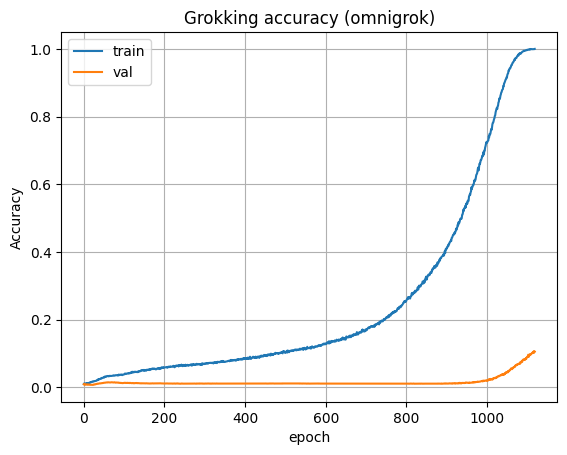

In [68]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Grokking accuracy (omnigrok)')# gamma= '+str(gamma))
plt.grid()
# plt.xscale('log')
#plt.savefig('exps/grokking_acc.pdf')
plt.show()

In [44]:
w_arr = {}

In [45]:
k = dct["epoch"]
while True:
    k += 1
    # на каждой эпохе перемешиваем train
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    counter = 0
    total_grad_norm = 0
    for data, is_train in [(training_set, True), (validation_set, False)]:

        total_acc = 0
        total_loss = 0
        net.train(is_train)
        
        dl = torch.split(data , batch_size, dim=0)  # делим на батчи
        for input in dl:  # input - 1 батч
            input = input.to(device)  # используем видеокарту
            with torch.set_grad_enabled(is_train):
                logits = net(input[:, :-1])  # предсказание
                loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
                total_loss += loss.item() * input.shape[0]
                
            if is_train:  # пересчитываем веса, вычисляя градиенты; обновляем lr
                
                net.zero_grad()
                loss.backward()
                optimizer.step()
                grad = calc_norm(net)
                total_grad_norm += grad
                counter += 1
                

            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
            
        if is_train:
            train_acc.append(total_acc / training_set.shape[0])
            train_loss.append(total_loss / training_set.shape[0])
        else:
            val_acc.append(total_acc / validation_set.shape[0])
            val_loss.append(total_loss / validation_set.shape[0])
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in net.parameters())))
            grad_norms.append(total_grad_norm / counter)
    if val_acc[-1] == 1:
        dct = {
            'epoch': k,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            "train_acc": train_acc, 
            "val_acc": val_acc, 
            "train_loss": train_loss, 
            "val_loss": val_loss,
            "norms":norms, 
            "grad_norms":grad_norms
        }
        torch.save(dct, "dct_val")
        break
    if k % 100 == 0:
        w_arr[k] = get_ravel_weights(net)
    print(f'Epoch {k}: Train / Val acc: {round(train_acc[-1], 4)} / {round(val_acc[-1], 4)}')


Epoch 581: Train / Val acc: 1.0 / 0.1197
Epoch 582: Train / Val acc: 1.0 / 0.1185
Epoch 583: Train / Val acc: 0.9997 / 0.1186
Epoch 584: Train / Val acc: 1.0 / 0.1212
Epoch 585: Train / Val acc: 0.9997 / 0.1212
Epoch 586: Train / Val acc: 0.9995 / 0.1231
Epoch 587: Train / Val acc: 0.9997 / 0.1235
Epoch 588: Train / Val acc: 0.9997 / 0.1242
Epoch 589: Train / Val acc: 1.0 / 0.1265
Epoch 590: Train / Val acc: 0.9997 / 0.1292
Epoch 591: Train / Val acc: 1.0 / 0.1317
Epoch 592: Train / Val acc: 1.0 / 0.1315
Epoch 593: Train / Val acc: 1.0 / 0.1331
Epoch 594: Train / Val acc: 1.0 / 0.1324
Epoch 595: Train / Val acc: 1.0 / 0.1378
Epoch 596: Train / Val acc: 1.0 / 0.1321
Epoch 597: Train / Val acc: 1.0 / 0.1362
Epoch 598: Train / Val acc: 1.0 / 0.1396
Epoch 599: Train / Val acc: 1.0 / 0.1405
Epoch 600: Train / Val acc: 1.0 / 0.1412
Epoch 601: Train / Val acc: 1.0 / 0.1435
Epoch 602: Train / Val acc: 1.0 / 0.1435
Epoch 603: Train / Val acc: 1.0 / 0.1407
Epoch 604: Train / Val acc: 1.0 / 0.143

KeyboardInterrupt: 

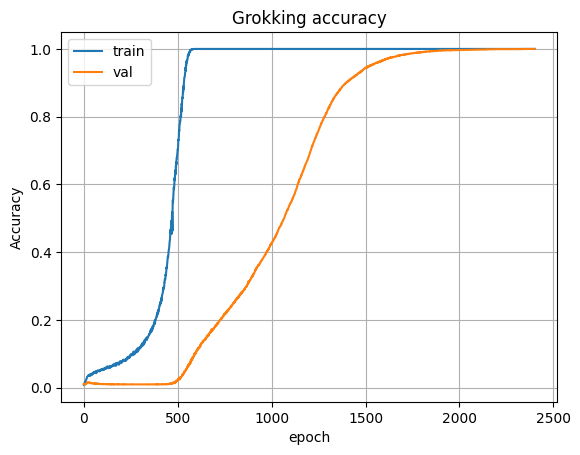

In [ ]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Grokking accuracy')
plt.grid()
# plt.xscale('log')
plt.savefig('exps/grokking_acc.pdf')
plt.show()

In [ ]:
dct_train = torch.load('dct_train')
dct_val = torch.load('dct_val')

In [ ]:
torch.save(w_arr, "weights")

In [ ]:
net.load_state_dict(dct_train["model_state_dict"])
w1 = get_ravel_weights(net)
k1 = dct_train['epoch']

net.load_state_dict(dct_val["model_state_dict"])
w2 = get_ravel_weights(net)
k2 = dct_val['epoch']

In [ ]:
k1, k2

(585, 2402)

In [ ]:
def init_wrt_t_pol_chain(w1, w2, theta, t):
    if t <= 0.5:
        return 2 * (t * theta + (0.5 - t) * w1)
    return 2 * ((t - 0.5) * w2 + (1 - t) * theta)




def get_ravel_weights(model):
    ww = []
    for par in model.parameters():
        ww.append(par.detach().cpu().data.numpy().ravel())
    return np.concatenate(ww)


def model_set_weights(xmodel, xweights):
    offset = 0
    for name, parameter in xmodel.named_parameters():
        size = np.prod(parameter.size())
        value = xweights[offset:offset+size].reshape(parameter.size())
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

In [ ]:
def init_wrt_t_pol_chain(w1, w2, theta, t):
    if t <= 0.5:
        return 2 * (t * theta + (0.5 - t) * w1)
    return 2 * ((t - 0.5) * w2 + (1 - t) * theta)




def get_ravel_weights(model):
    ww = []
    for par in model.parameters():
        ww.append(par.detach().cpu().data.numpy().ravel())
    return np.concatenate(ww)


def model_set_weights(xmodel, xweights):
    offset = 0
    for name, parameter in xmodel.named_parameters():
        size = np.prod(parameter.size())
        value = xweights[offset:offset+size].reshape(parameter.size())
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

In [ ]:
def segment(w1, w2, t):
    return w2*t + w1*(1-t)

## Segment

In [ ]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(training_set , batch_size, dim=0)
train_loss_segment = []
grad_norms_segment = []
train_err_segment = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = segment(w1, w2, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        net.zero_grad()
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        acc = (logits.argmax(-1) == input[:, -1]).float().mean()
        total_acc += acc.item()*input.shape[0]
        loss.backward()
        grad = calc_norm(net)
        total_norm += grad
        counter += 1
    grad_norms_segment.append(total_norm / counter)
    train_err_segment.append(1 - total_acc / training_set.shape[0])
    train_loss_segment.append(total_loss/training_set.shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(validation_set , batch_size, dim=0)
val_loss_segment = []
val_err_segment = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = segment(w1, w2, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        with torch.no_grad():
            input = input.to(device)  # используем видеокарту
            logits = net(input[:, :-1])  # предсказание
            loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
            total_loss += loss.item() * input.shape[0]
            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
    val_err_segment.append(1 - total_acc / validation_set.shape[0])
    val_loss_segment.append(total_loss/validation_set.shape[0])


  0%|          | 0/1000 [00:00<?, ?it/s]

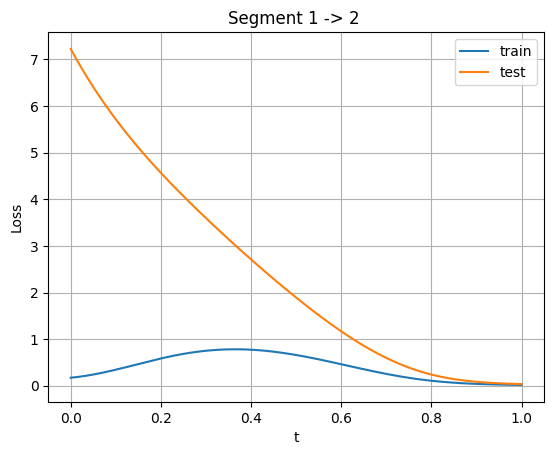

In [ ]:
plt.plot(alpha_range, train_loss_segment, label='train')
plt.plot(alpha_range, val_loss_segment, label='test')
plt.grid()
plt.title('Segment 1 -> 2 ')
plt.xlabel('t')
plt.ylabel('Loss')
plt.legend()
plt.savefig('exps/1_segment/train_val_loss.pdf')
plt.show()

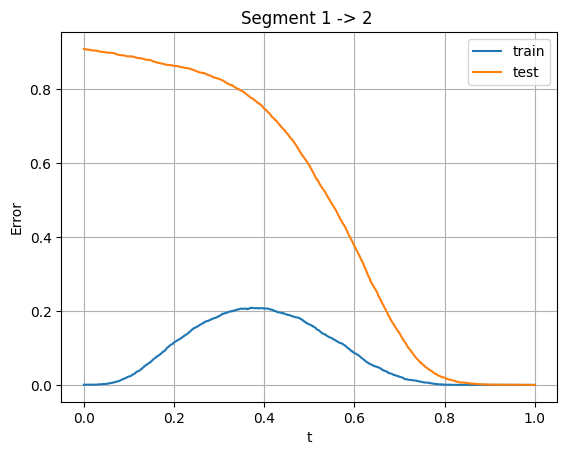

In [ ]:
plt.plot(alpha_range, train_err_segment, label='train')
plt.plot(alpha_range, val_err_segment, label='test')
plt.grid()
plt.xlabel('t')
plt.title('Segment 1 -> 2 ')
plt.ylabel('Error')
plt.legend()
plt.savefig('exps/1_segment/train_val_err.pdf')
plt.show()

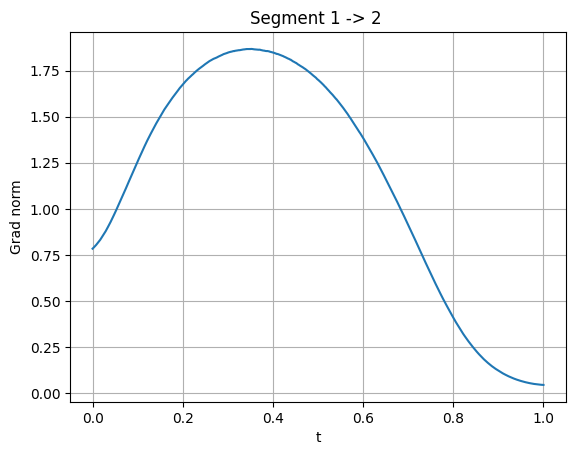

In [ ]:
plt.plot(alpha_range, grad_norms_segment)
plt.grid()
plt.title('Segment 1 -> 2 ')
plt.xlabel('t')
plt.ylabel('Grad norm')
plt.savefig('exps/1_segment/grad_norm.pdf')
plt.show()

## Many segments

In [ ]:
w_keys = list(w_arr.keys())
w_keys

[600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400]

In [ ]:
w_keys[0] = k1
w_keys[-1] = k2
w_keys

[585,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2402]

In [98]:
ww = list(w_arr.values())
ww[0] = w1
ww[-1] = w2

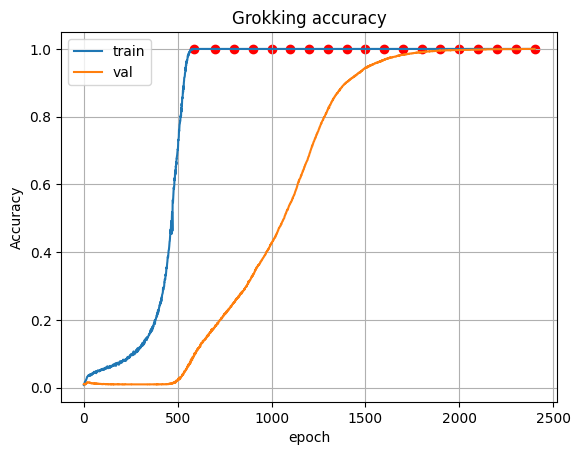

In [336]:
plt.plot(dct_val["train_acc"], label='train')
plt.plot(dct_val["val_acc"], label='val')
plt.scatter(w_keys, np.ones_like(w_keys), c='r')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Grokking accuracy')
plt.grid()
#plt.xscale('log')
plt.savefig('exps/many_segment/grokking_acc.pdf')
plt.show()

In [112]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(training_set , batch_size, dim=0)
train_err_all = []
train_loss_all = []
grad_norm_all = []
for i in range(len(w_keys) - 1):
    
    train_loss_segment = []
    grad_norms_segment = []
    train_err_segment = []
    for a in tqdm(alpha_range):
        total_loss = 0
        total_acc = 0
        total_norm = 0
        phi = segment(ww[i], ww[i+1], a)
        model_set_weights(net, phi)
        counter = 0 
        for input in dl:  # input - 1 батч
            net.zero_grad()
            input = input.to(device)  # используем видеокарту
            logits = net(input[:, :-1])  # предсказание
            loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
            total_loss += loss.item() * input.shape[0]
            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
            loss.backward()
            grad = calc_norm(net)
            total_norm += grad
            counter += 1
        grad_norms_segment.append(total_norm / counter)
        train_err_segment.append(1 - total_acc / training_set.shape[0])
        train_loss_segment.append(total_loss / training_set.shape[0])
    train_err_all.append(train_err_segment)
    train_loss_all.append(train_loss_segment)
    grad_norm_all.append(grad_norms_segment)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [113]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(validation_set , batch_size, dim=0)
val_err_all = []
val_loss_all = []
for i in range(len(w_keys) - 1):
    
    val_loss_segment = []
    val_err_segment = []
    for a in tqdm(alpha_range):
        total_loss = 0
        total_acc = 0
        total_norm = 0
        phi = segment(ww[i], ww[i+1], a)
        model_set_weights(net, phi)
        counter = 0 
        for input in dl:  # input - 1 батч
            with torch.no_grad():
                input = input.to(device)  # используем видеокарту
                logits = net(input[:, :-1])  # предсказание
                loss = cross_entropy(
                        logits, input[:, -1].flatten().to(torch.long))
                total_loss += loss.item() * input.shape[0]
                acc = (logits.argmax(-1) == input[:, -1]).float().mean()
                total_acc += acc.item()*input.shape[0]
        val_err_segment.append(1 - total_acc / validation_set.shape[0])
        val_loss_segment.append(total_loss / validation_set.shape[0])
    val_err_all.append(val_err_segment)
    val_loss_all.append(val_loss_segment)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

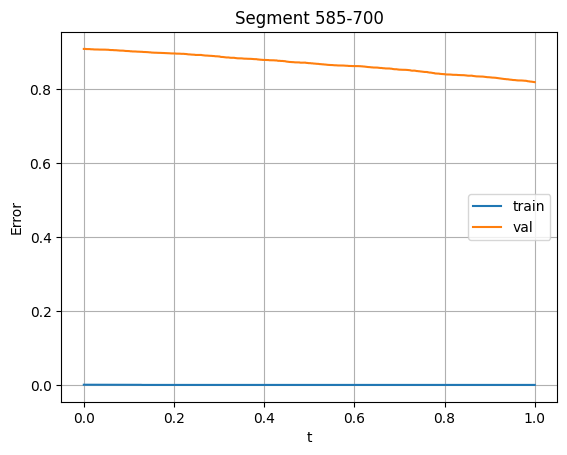

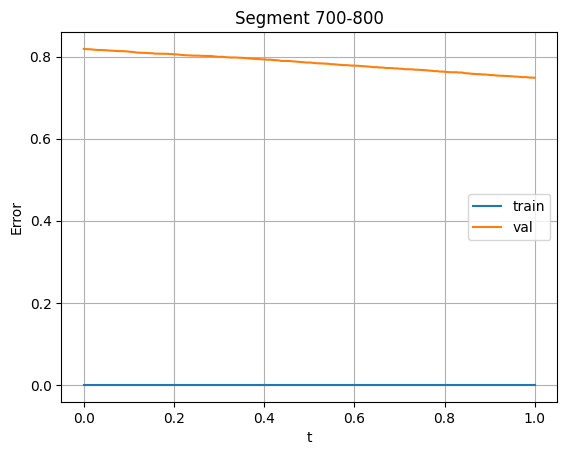

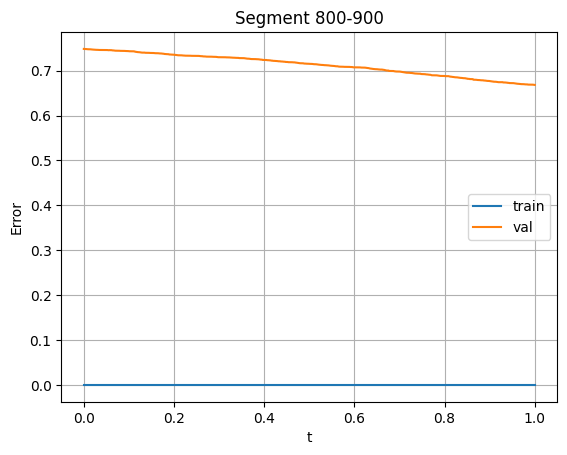

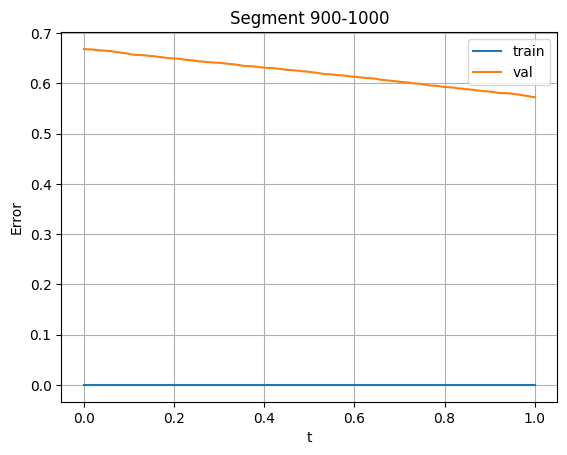

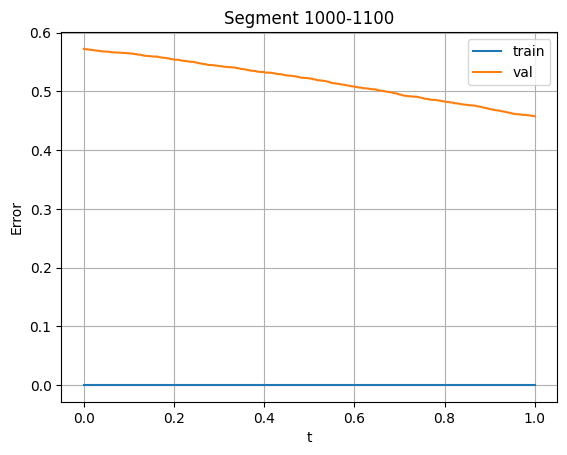

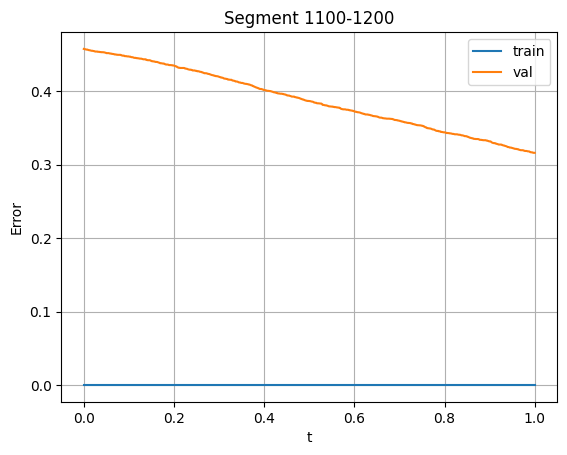

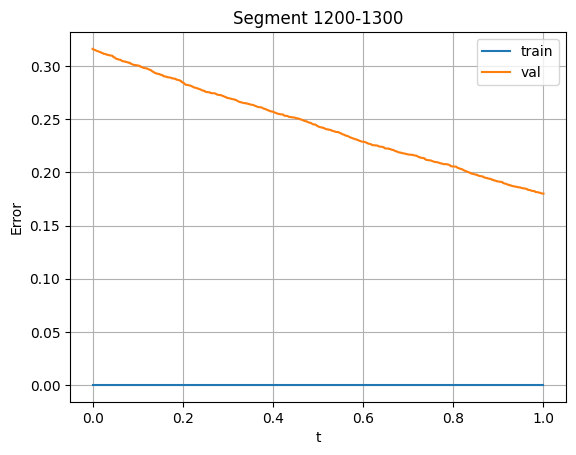

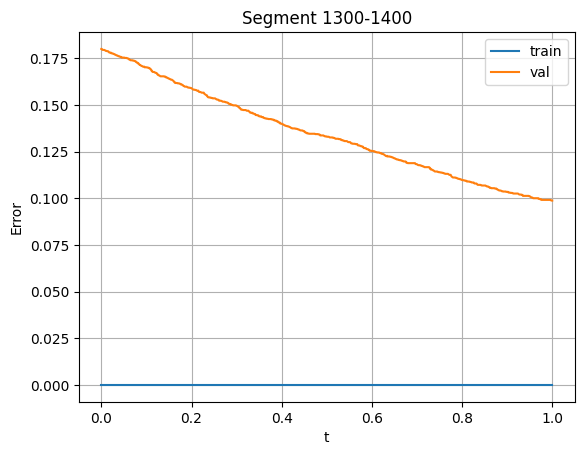

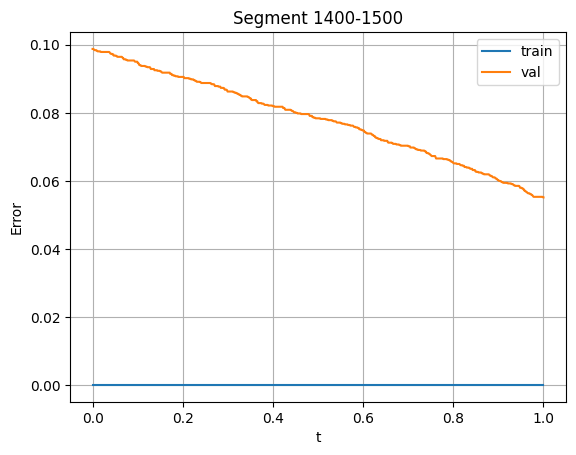

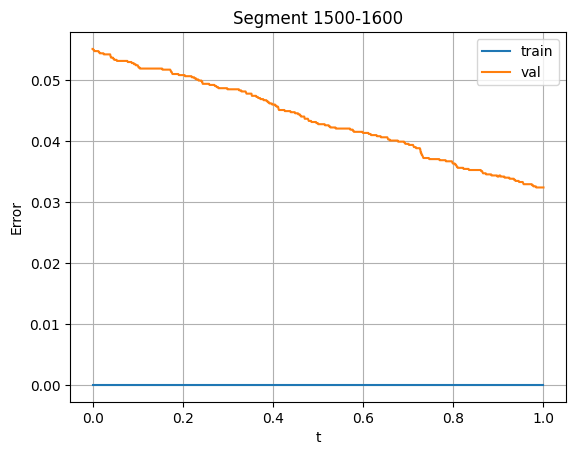

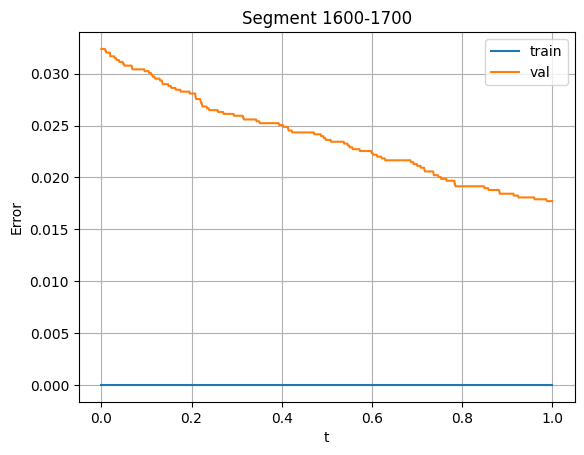

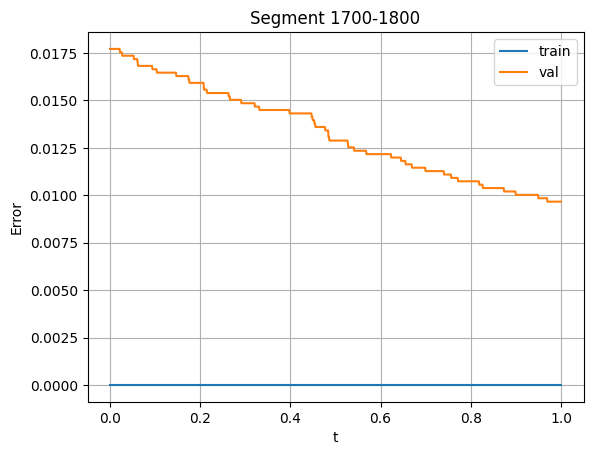

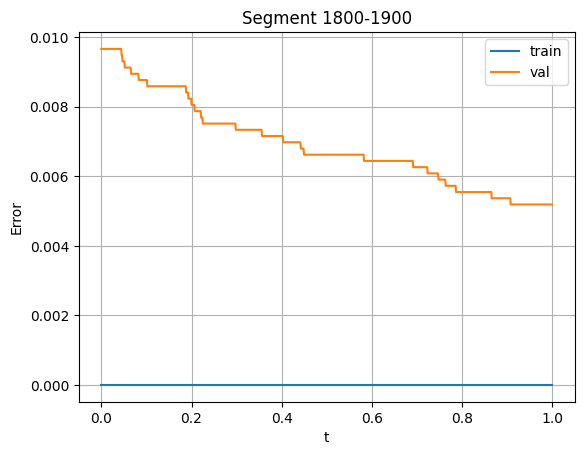

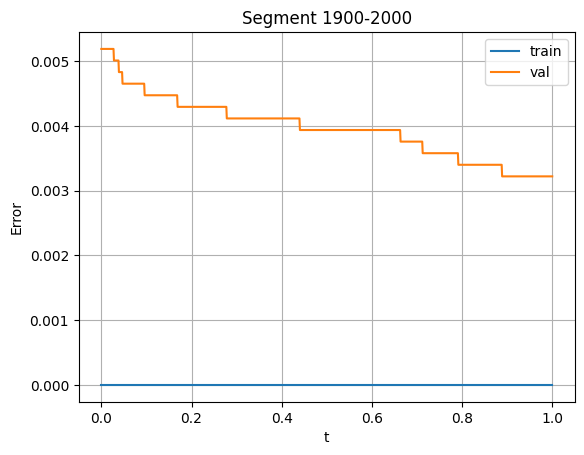

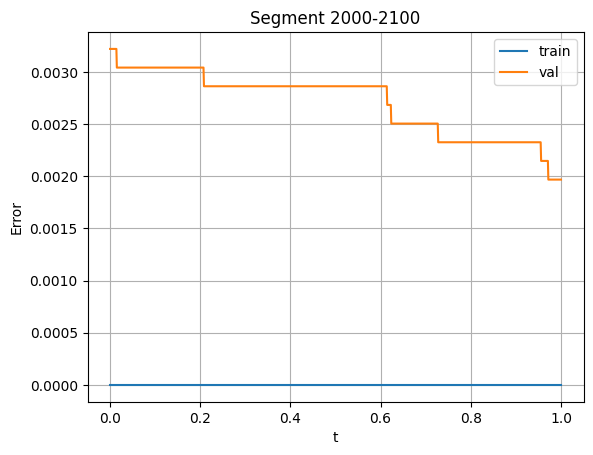

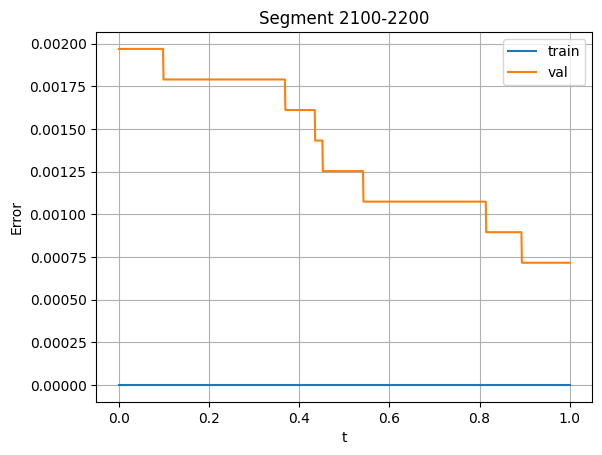

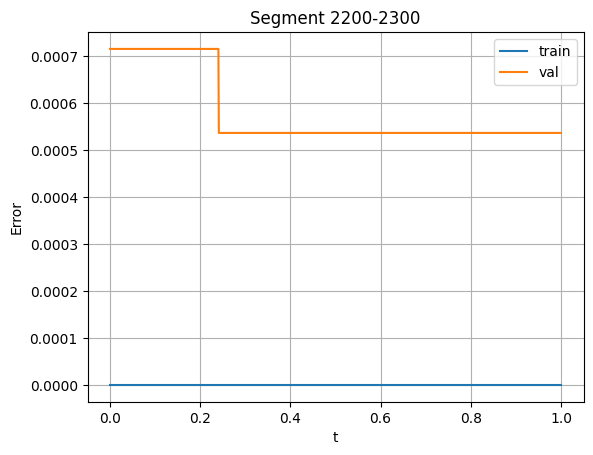

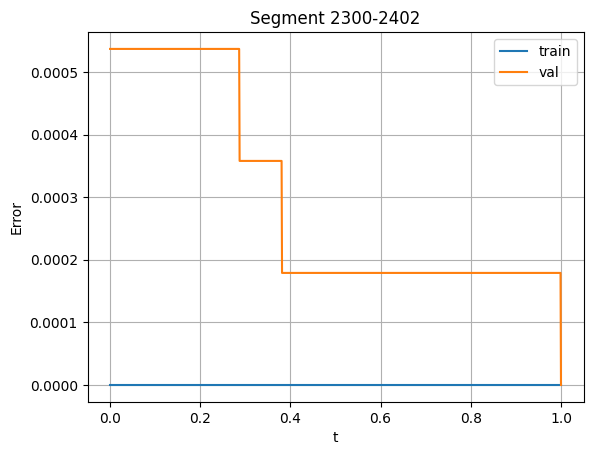

In [126]:
for i in range(len(w_keys) - 1):
    k = w_keys[i]
    kk = w_keys[i+1]
    plt.title("Segment " + str(k)+'-'+str(kk))
    plt.xlabel('t')
    plt.ylabel('Error')
    plt.plot(alpha_range, train_err_all[i], label='train')
    plt.plot(alpha_range, val_err_all[i], label='val')
    plt.legend()
    plt.grid()
    plt.savefig("exps/many_segment/Error/train_val_err_"+str(k)+'_'+str(kk)+'.pdf')
    plt.show()

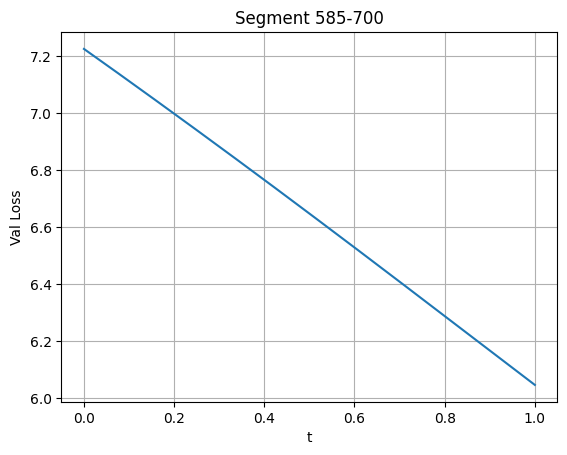

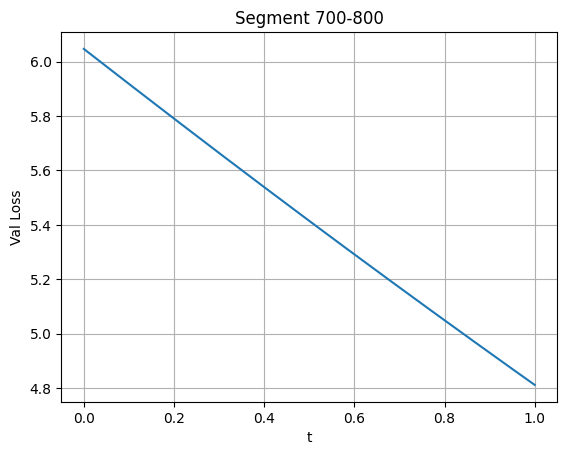

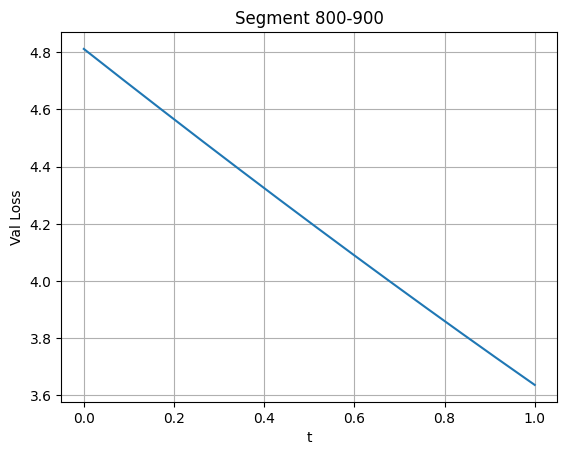

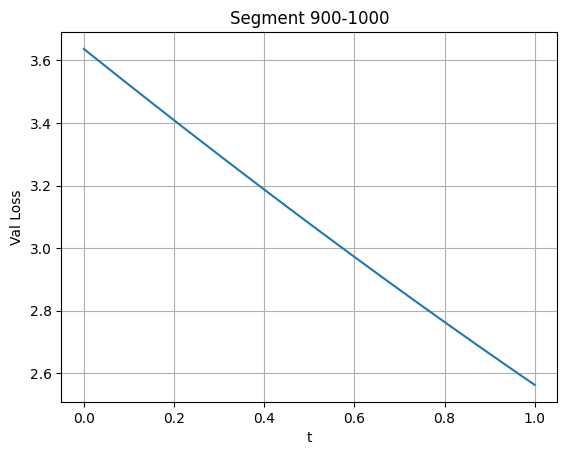

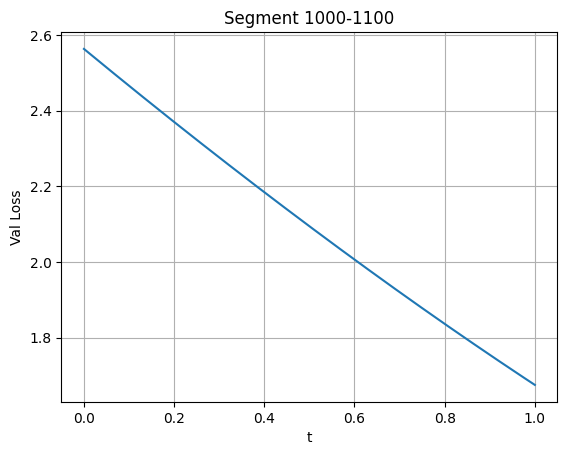

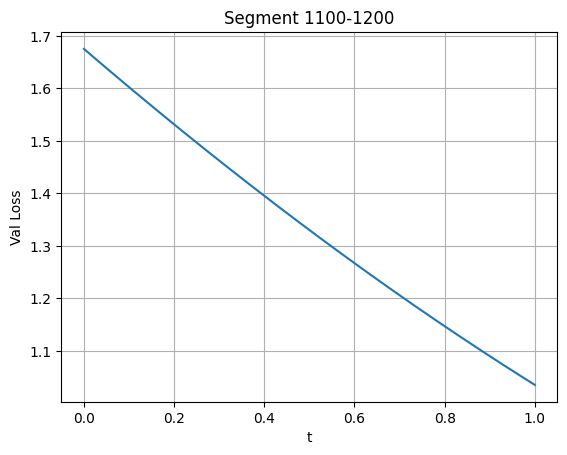

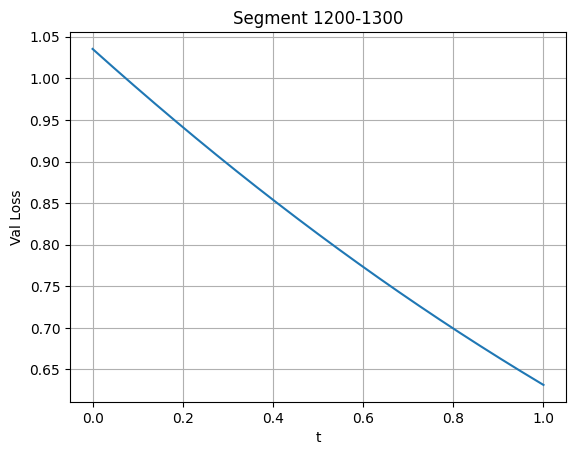

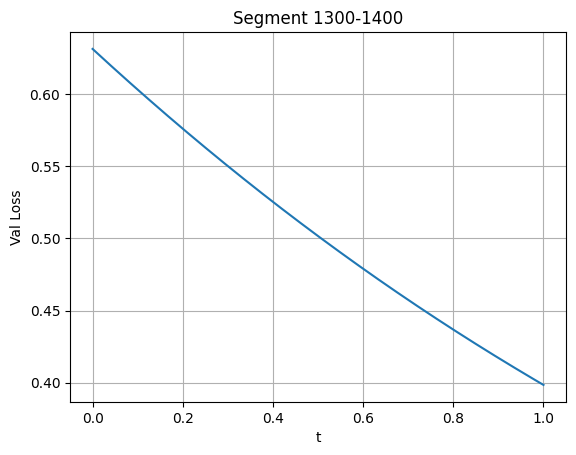

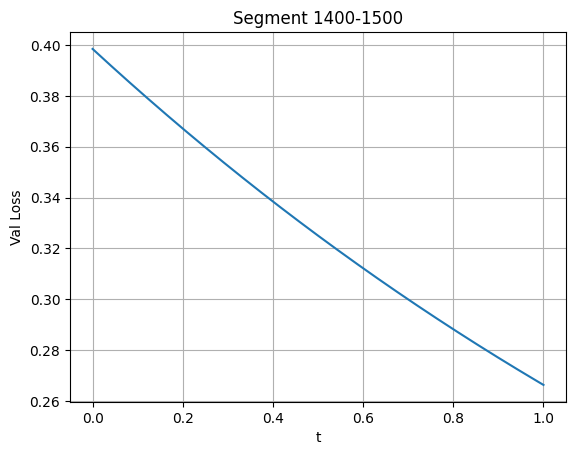

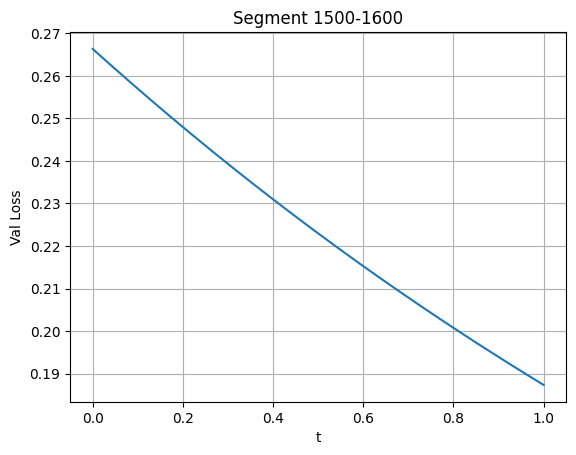

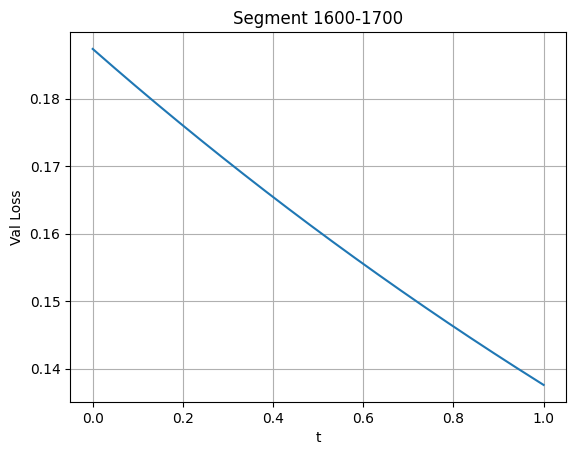

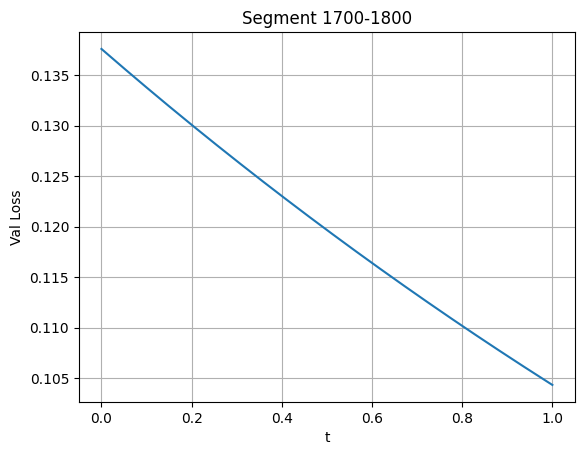

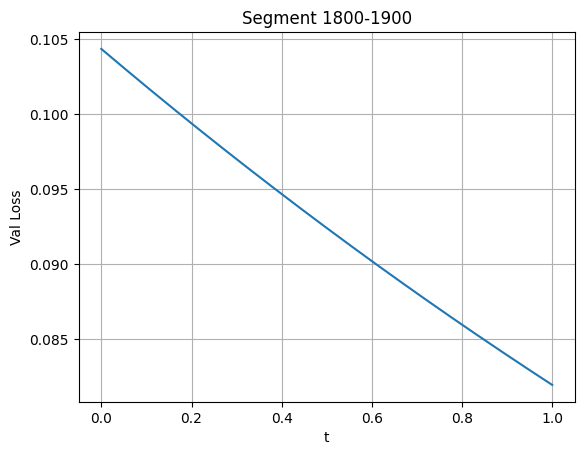

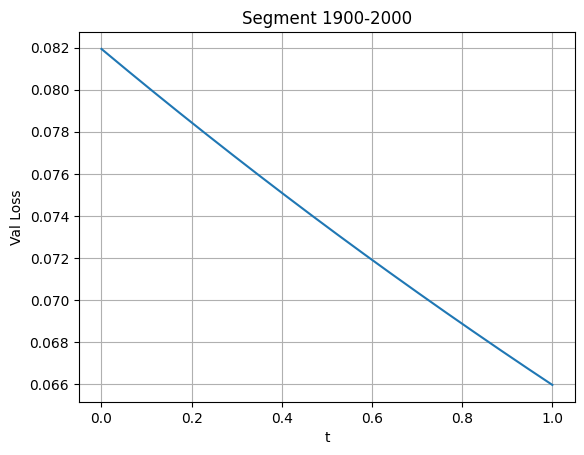

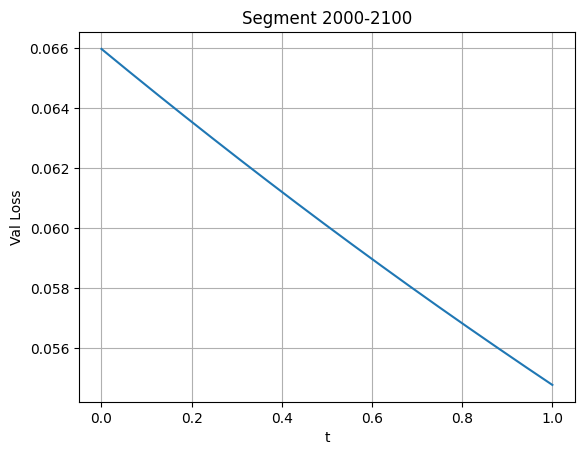

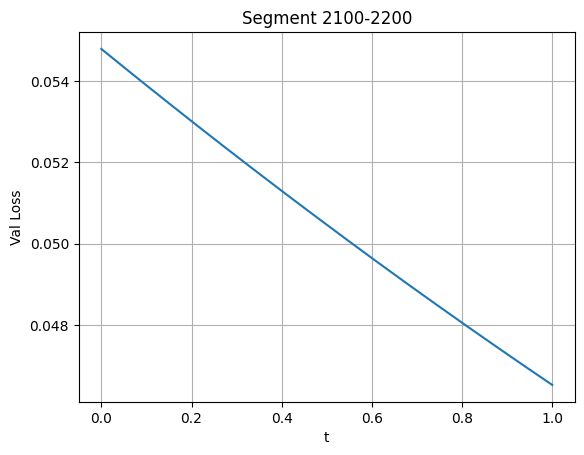

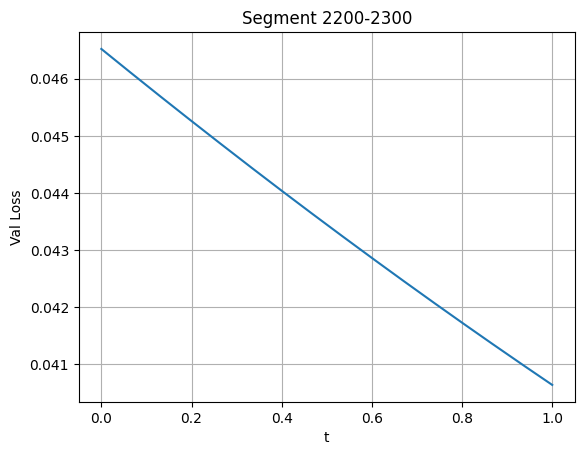

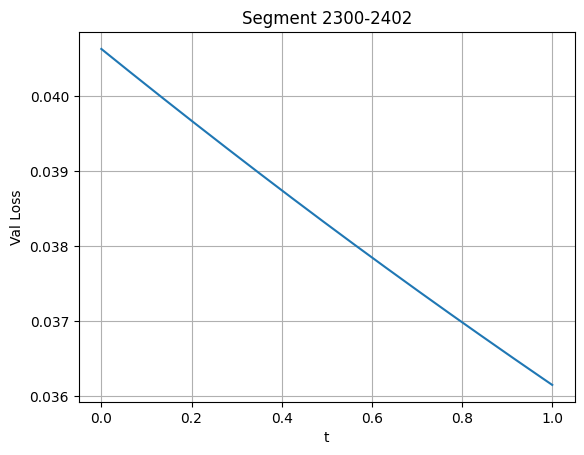

In [135]:
for i in range(len(w_keys) - 1):
    k = w_keys[i]
    kk = w_keys[i+1]
    plt.title("Segment " + str(k)+'-'+str(kk))
    plt.xlabel('t')
    plt.ylabel('Val Loss')
    #plt.plot(alpha_range, train_loss_all[i])
    plt.grid()
    plt.plot(alpha_range, val_loss_all[i])
    plt.savefig("exps/many_segment/Loss/val/val_loss_"+str(k)+'_'+str(kk)+'.pdf')
    plt.show()

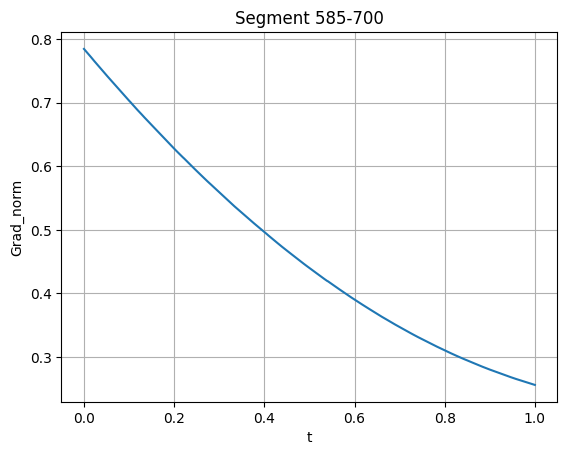

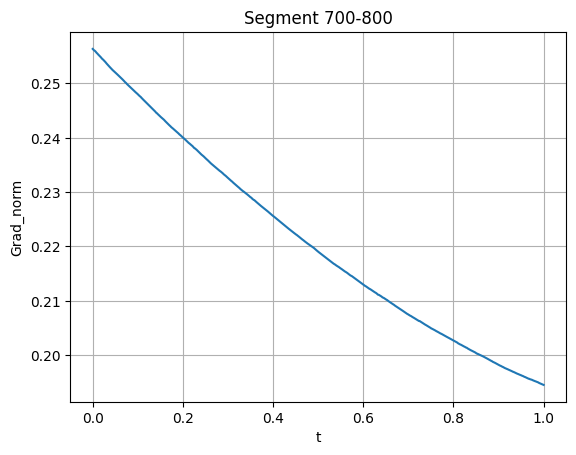

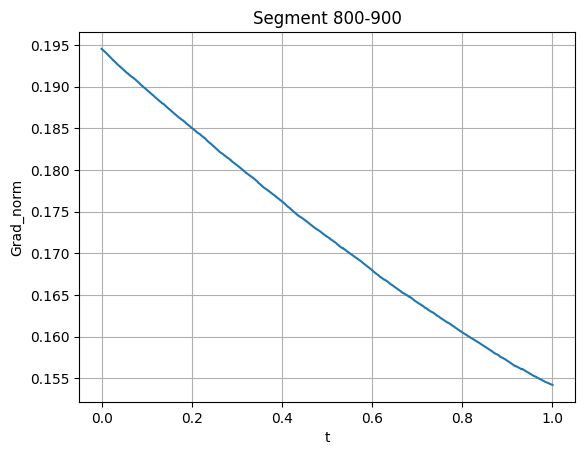

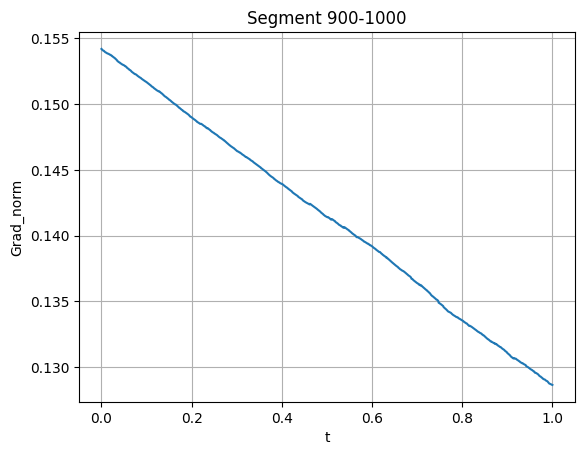

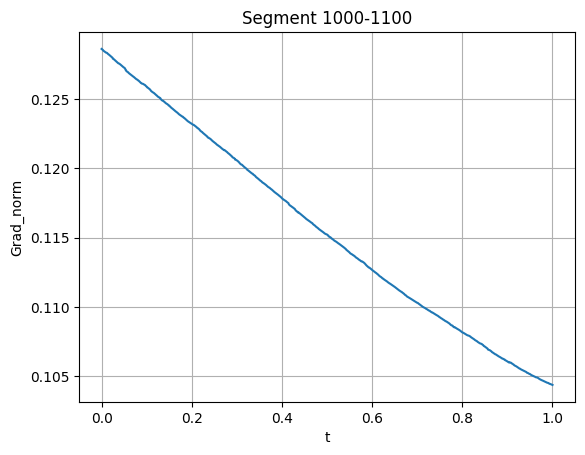

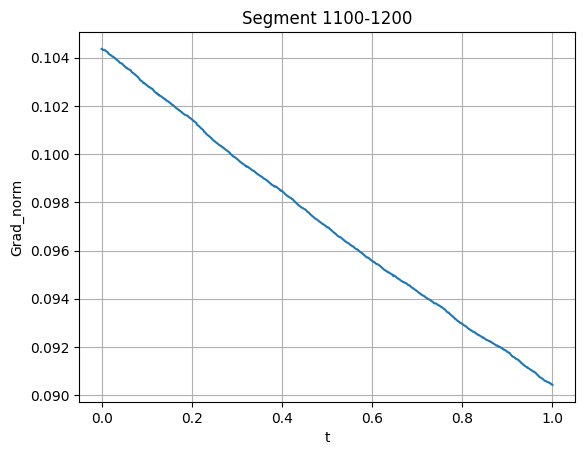

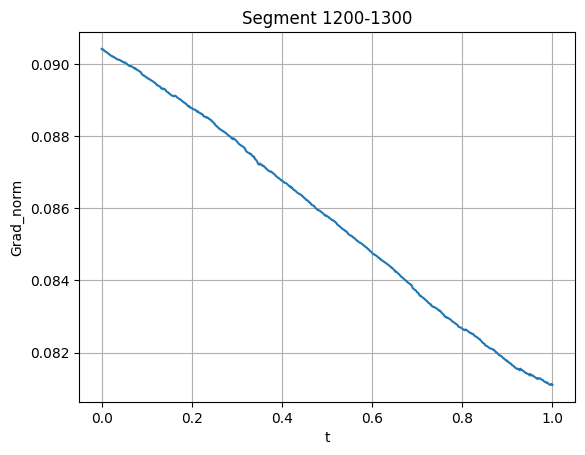

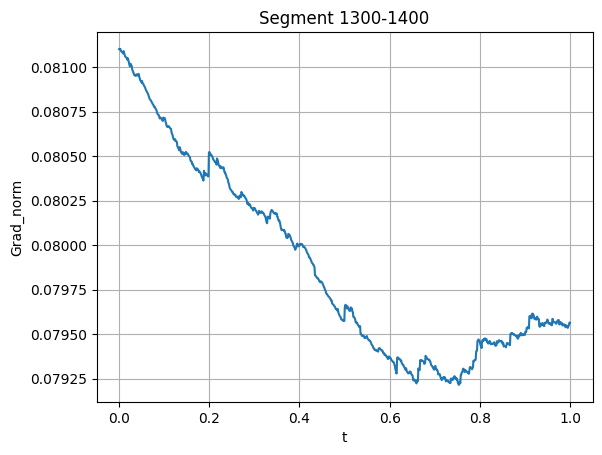

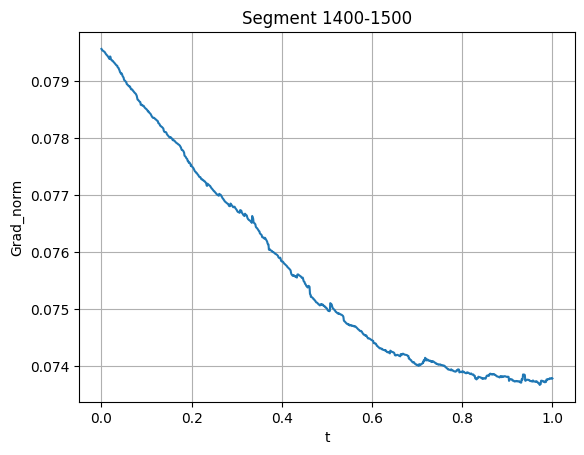

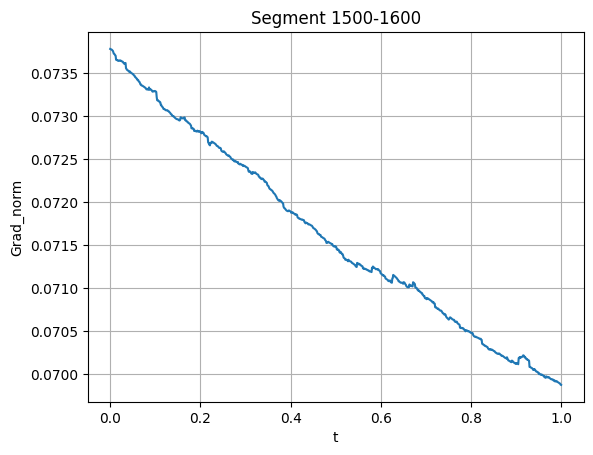

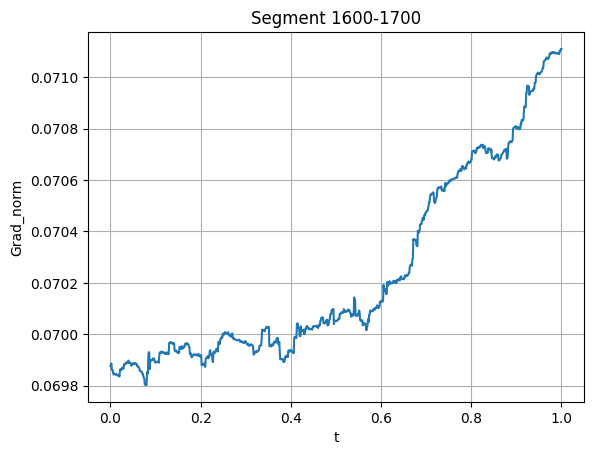

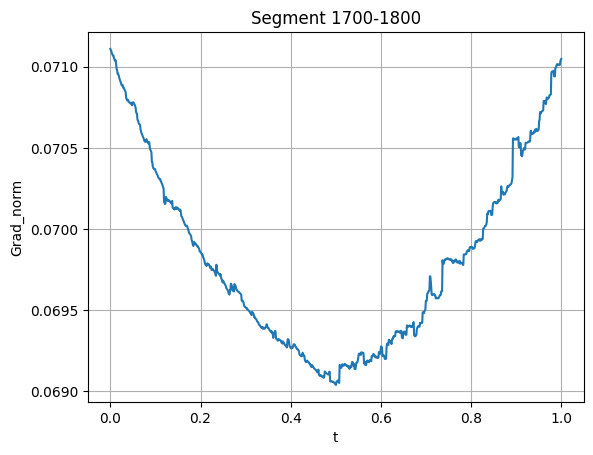

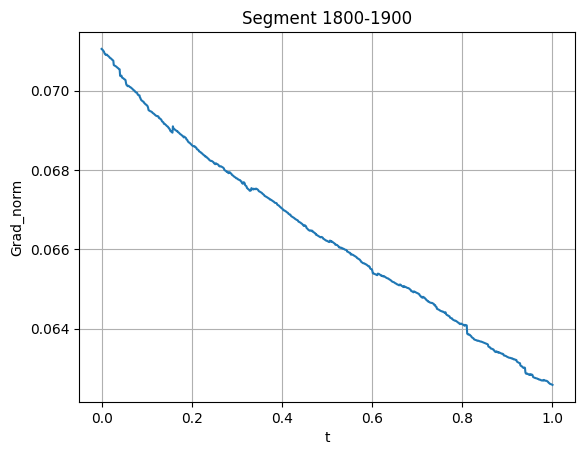

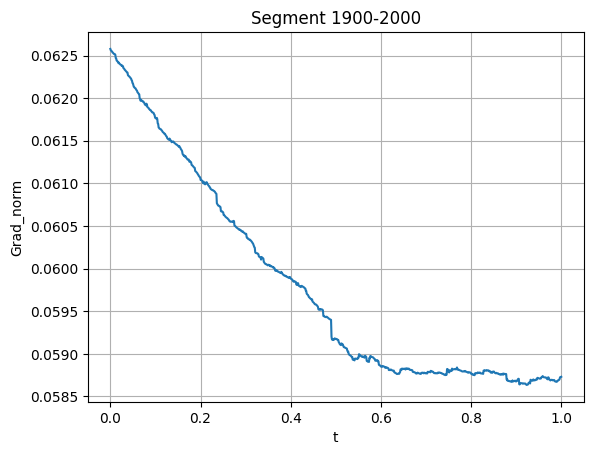

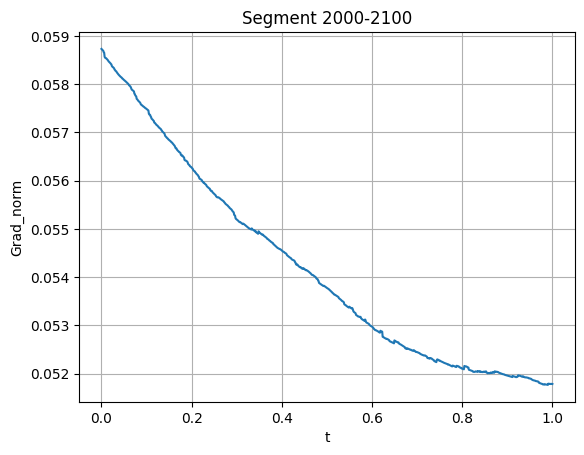

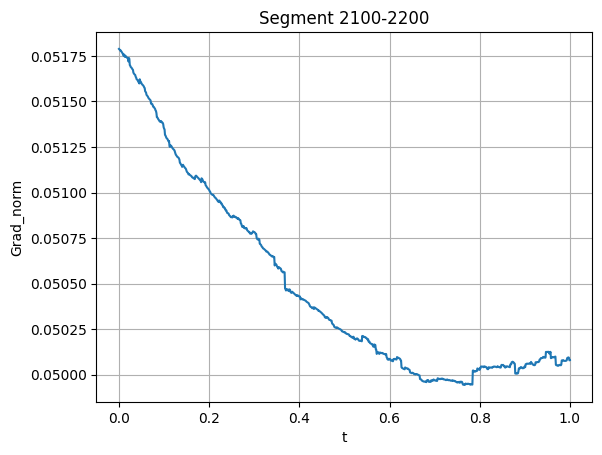

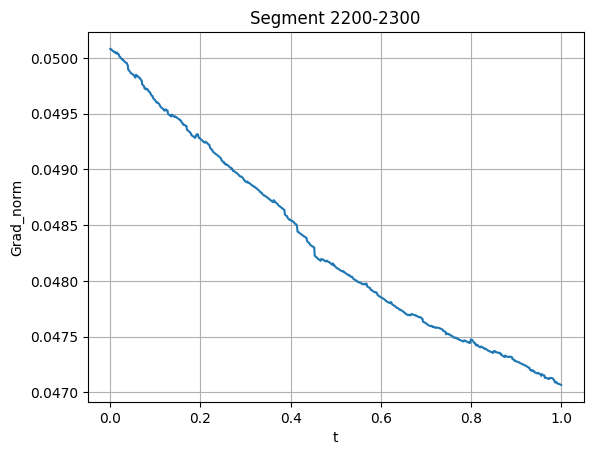

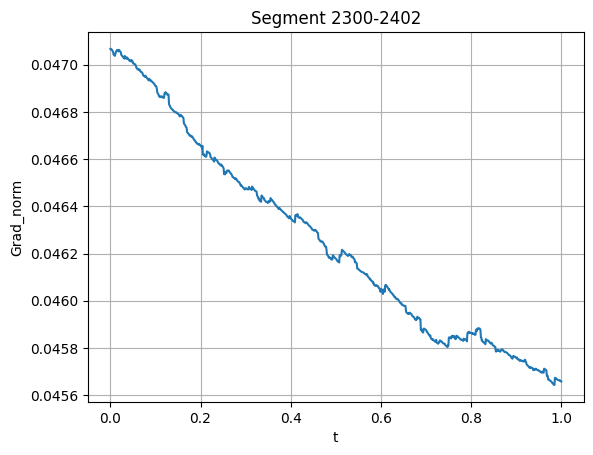

In [131]:
for i in range(len(w_keys) - 1):
    k = w_keys[i]
    kk = w_keys[i+1]
    plt.title("Segment " + str(k)+'-'+str(kk))
    plt.xlabel('t')
    plt.ylabel('Grad_norm')
    plt.plot(alpha_range, grad_norm_all[i])
    plt.grid()
    #plt.plot(alpha_range, val_loss_all[i], label='val')
    plt.savefig("exps/many_segment/Grad_norm/grad_norm_"+str(k)+'_'+str(kk)+'.pdf')
    plt.show()

## Connect 1 and 2

In [215]:
tetta0 = (w1+w2)/2
num_iter = 1000

In [216]:
net =   Transformer(num_layers=1, 
                    d_vocab=p, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=2, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)
net.train(True)
optimizer = SGD(net.parameters(), lr=1e-1)

In [217]:
tetta = tetta0
train_loss_teta = []

In [218]:

for j in range(num_iter):
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    dl = torch.split(training_set , batch_size, dim=0)
    total_loss = 0
    for input in dl:  # input - 1 батч
        t = torch.rand(1)
        phi = init_wrt_t_pol_chain(w1, w2, tetta, t).detach().cpu().data.numpy()
        model_set_weights(net, phi)
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        net.zero_grad()
        loss.backward()

        if t <= 0.5:
            dphi = 2*t
        else:
            dphi = 2*(1-t)
        grad_arr = [] 
        dphi = dphi.to(device)
        for name, w in net.named_parameters():
            grad_arr.append(w.grad*dphi)
        model_set_weights(net, tetta)
        for i, (name, w) in enumerate(net.named_parameters()):
            w.grad = grad_arr[i]
        optimizer.step()
        tetta = get_ravel_weights(net)
    train_loss_teta.append(total_loss / training_set.shape[0])
    print(f'Epoch {j}: Train loss: {total_loss / training_set.shape[0]}')
    

Epoch 0: Train loss: 0.30534513545983843
Epoch 1: Train loss: 0.3418725427444204
Epoch 2: Train loss: 0.3776356016518798
Epoch 3: Train loss: 0.23290679627023117
Epoch 4: Train loss: 0.18086194476686923
Epoch 5: Train loss: 0.2921616629958473
Epoch 6: Train loss: 0.27963295527738863
Epoch 7: Train loss: 0.18322995529138952
Epoch 8: Train loss: 0.3035540446943166
Epoch 9: Train loss: 0.21784162982321964
Epoch 10: Train loss: 0.2690139407918225
Epoch 11: Train loss: 0.26364002934588016
Epoch 12: Train loss: 0.25645788399668695
Epoch 13: Train loss: 0.20490627088428953
Epoch 14: Train loss: 0.18505600358886698
Epoch 15: Train loss: 0.23158547165378465
Epoch 16: Train loss: 0.1751615414045807
Epoch 17: Train loss: 0.208392408031222
Epoch 18: Train loss: 0.09318719738664227
Epoch 19: Train loss: 0.13333123004430092
Epoch 20: Train loss: 0.2754043692164723
Epoch 21: Train loss: 0.14627610341066577
Epoch 22: Train loss: 0.12990866164515788
Epoch 23: Train loss: 0.19632313201237955
Epoch 24: T

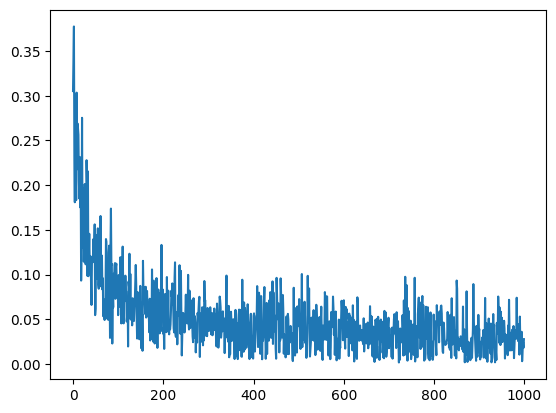

In [219]:
plt.plot(train_loss_teta)

In [220]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(training_set , batch_size, dim=0)
train_loss_pc = []
grad_norms_pc = []
train_err_pc = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = init_wrt_t_pol_chain(w1, w2, tetta, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        net.zero_grad()
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        acc = (logits.argmax(-1) == input[:, -1]).float().mean()
        total_acc += acc.item()*input.shape[0]
        loss.backward()
        grad = calc_norm(net)
        total_norm += grad
        counter += 1
    grad_norms_pc.append(total_norm / counter)
    train_err_pc.append(1 - total_acc / training_set.shape[0])
    train_loss_pc.append(total_loss/training_set.shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [221]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(validation_set , batch_size, dim=0)
val_loss_pc = []
val_err_pc = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = init_wrt_t_pol_chain(w1, w2, tetta, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        with torch.no_grad():
            input = input.to(device)  # используем видеокарту
            logits = net(input[:, :-1])  # предсказание
            loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
            total_loss += loss.item() * input.shape[0]
            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
    val_err_pc.append(1 - total_acc / validation_set.shape[0])
    val_loss_pc.append(total_loss/validation_set.shape[0])


  0%|          | 0/1000 [00:00<?, ?it/s]

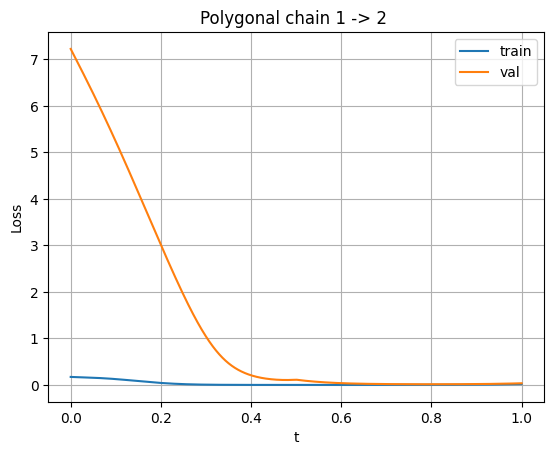

In [222]:
plt.plot(alpha_range, train_loss_pc, label='train')
plt.plot(alpha_range, val_loss_pc, label='val')
plt.grid()
plt.title('Polygonal chain 1 -> 2 ')
plt.xlabel('t')
plt.legend()
plt.ylabel('Loss')
plt.savefig('exps/pol_chain12/train_val_loss.pdf')
plt.show()

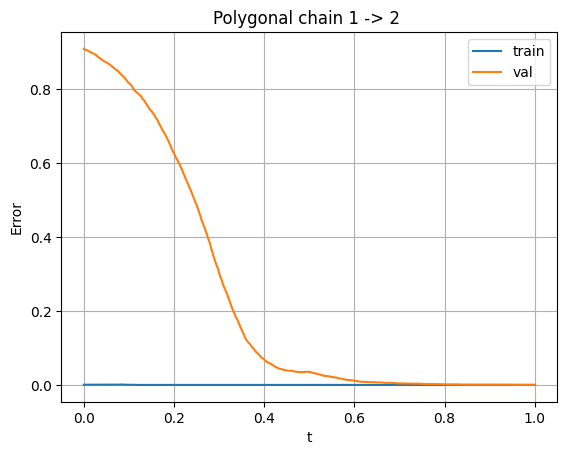

In [223]:
plt.plot(alpha_range, train_err_pc, label='train')
plt.plot(alpha_range, val_err_pc, label='val')
plt.grid()
plt.title('Polygonal chain 1 -> 2 ')
plt.xlabel('t')
plt.legend()
plt.ylabel('Error')
plt.savefig('exps/pol_chain12/train_val_err.pdf')
plt.show()

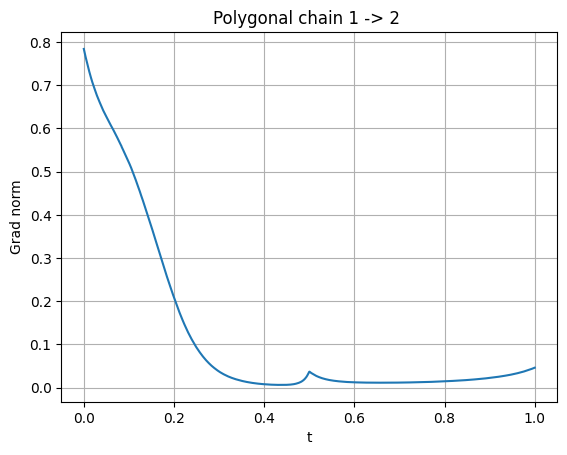

In [224]:
plt.plot(alpha_range, grad_norms_pc)
plt.grid()
plt.title('Polygonal chain 1 -> 2 ')
plt.xlabel('t')
plt.ylabel('Grad norm')
plt.savefig('exps/pol_chain12/grad_norm.pdf')
plt.show()

## Connect 1 and 1'

In [69]:

net =   Transformer(num_layers=1, 
                    d_vocab=p, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=2, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)
optimizer = SGD(net.parameters(), lr=1e-1, weight_decay=0.001)

In [70]:
train_acc, val_acc, train_loss, val_loss, norms, grad_norms = [], [], [], [], [], []

In [71]:

k = 0
while True:
    k += 1
    # на каждой эпохе перемешиваем train
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    counter = 0
    total_grad_norm = 0
    for data, is_train in [(training_set, True), (validation_set, False)]:
    
        total_acc = 0
        total_loss = 0
        net.train(is_train)
        
        dl = torch.split(data , batch_size, dim=0)  # делим на батчи
        for input in dl:  # input - 1 батч
            input = input.to(device)  # используем видеокарту
            with torch.set_grad_enabled(is_train):
                logits = net(input[:, :-1])  # предсказание
                loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
                total_loss += loss.item() * input.shape[0]
                
            if is_train:  # пересчитываем веса, вычисляя градиенты; обновляем lr
                
                net.zero_grad()
                loss.backward()
                optimizer.step()
                grad = calc_norm(net)
                total_grad_norm += grad
                counter += 1
                

            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
            
        if is_train:
            train_acc.append(total_acc / training_set.shape[0])
            train_loss.append(total_loss / training_set.shape[0])
        else:
            val_acc.append(total_acc / validation_set.shape[0])
            val_loss.append(total_loss / validation_set.shape[0])
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in net.parameters())))
            grad_norms.append(total_grad_norm / counter)
    if train_acc[-1] == 1:
        dct = {
            'epoch': k,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            "train_acc": train_acc, 
            "val_acc": val_acc, 
            "train_loss": train_loss, 
            "val_loss": val_loss,
            "norms":norms, 
            "grad_norms":grad_norms
        }
        torch.save(dct, "dct_train_new")
        break
    print(f'Epoch {k}: Train / Val acc: {round(train_acc[-1], 4)} / {round(val_acc[-1], 4)}')


Epoch 1: Train / Val acc: 0.0107 / 0.0109
Epoch 2: Train / Val acc: 0.011 / 0.0107
Epoch 3: Train / Val acc: 0.0115 / 0.01
Epoch 4: Train / Val acc: 0.0137 / 0.0102
Epoch 5: Train / Val acc: 0.0158 / 0.01
Epoch 6: Train / Val acc: 0.0166 / 0.0107
Epoch 7: Train / Val acc: 0.0172 / 0.0106
Epoch 8: Train / Val acc: 0.018 / 0.0118
Epoch 9: Train / Val acc: 0.018 / 0.0113
Epoch 10: Train / Val acc: 0.0183 / 0.0111
Epoch 11: Train / Val acc: 0.0177 / 0.0118
Epoch 12: Train / Val acc: 0.0196 / 0.0125
Epoch 13: Train / Val acc: 0.022 / 0.0131
Epoch 14: Train / Val acc: 0.0215 / 0.0131
Epoch 15: Train / Val acc: 0.0209 / 0.0123
Epoch 16: Train / Val acc: 0.0223 / 0.0132
Epoch 17: Train / Val acc: 0.0231 / 0.0132
Epoch 18: Train / Val acc: 0.0244 / 0.0141
Epoch 19: Train / Val acc: 0.0258 / 0.0145
Epoch 20: Train / Val acc: 0.026 / 0.0154
Epoch 21: Train / Val acc: 0.0274 / 0.0163
Epoch 22: Train / Val acc: 0.0287 / 0.0168
Epoch 23: Train / Val acc: 0.0295 / 0.0172
Epoch 24: Train / Val acc: 0.

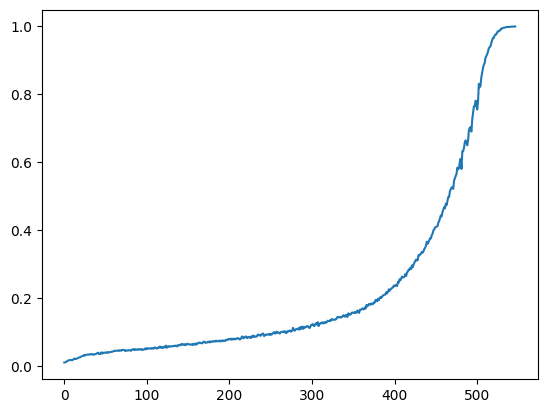

In [72]:
plt.plot(train_acc)

In [73]:
dct_train_new = torch.load('dct_train_new')
net.load_state_dict(dct_train_new['model_state_dict'])
w11 = get_ravel_weights(net)


In [74]:
tetta0 = (w1+w11)/2
num_iter = 1000

NameError: name 'w1' is not defined

In [452]:
net =   Transformer(num_layers=1, 
                    d_vocab=p, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=2, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)
net.train(True)
optimizer = SGD(net.parameters(), lr=1e-1)

In [453]:
tetta = tetta0
train_loss_teta = []

In [454]:

for j in range(num_iter):
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    dl = torch.split(training_set , batch_size, dim=0)
    total_loss = 0
    for input in dl:  # input - 1 батч
        t = torch.rand(1)
        phi = init_wrt_t_pol_chain(w1, w11, tetta, t).detach().cpu().data.numpy()
        model_set_weights(net, phi)
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        net.zero_grad()
        loss.backward()

        if t <= 0.5:
            dphi = 2*t
        else:
            dphi = 2*(1-t)
        grad_arr = [] 
        dphi = dphi.to(device)
        for name, w in net.named_parameters():
            grad_arr.append(w.grad*dphi)
        model_set_weights(net, tetta)
        for i, (name, w) in enumerate(net.named_parameters()):
            w.grad = grad_arr[i]
        optimizer.step()
        tetta = get_ravel_weights(net)
    train_loss_teta.append(total_loss / training_set.shape[0])
    print(f'Epoch {j}: Train loss: {total_loss / training_set.shape[0]}')
    

Epoch 0: Train loss: 2.9607348872306654
Epoch 1: Train loss: 3.160544232318276
Epoch 2: Train loss: 2.404493176719428
Epoch 3: Train loss: 2.3784583905585728
Epoch 4: Train loss: 3.0864528895192707
Epoch 5: Train loss: 2.1709311838180754
Epoch 6: Train loss: 3.49435264826077
Epoch 7: Train loss: 2.211894881328374
Epoch 8: Train loss: 2.1641569558839153
Epoch 9: Train loss: 2.5252099298380886
Epoch 10: Train loss: 3.231774749356361
Epoch 11: Train loss: 1.790373647795584
Epoch 12: Train loss: 2.8448362173762667
Epoch 13: Train loss: 2.827302741312955
Epoch 14: Train loss: 2.360964077883965
Epoch 15: Train loss: 2.4911677950050852
Epoch 16: Train loss: 2.5855228091989244
Epoch 17: Train loss: 3.278929849700436
Epoch 18: Train loss: 2.3225955614854135
Epoch 19: Train loss: 2.225431899122982
Epoch 20: Train loss: 2.3392398843959885
Epoch 21: Train loss: 2.2354352868589245
Epoch 22: Train loss: 2.0644308521015176
Epoch 23: Train loss: 1.7361595830394938
Epoch 24: Train loss: 2.1317199331605

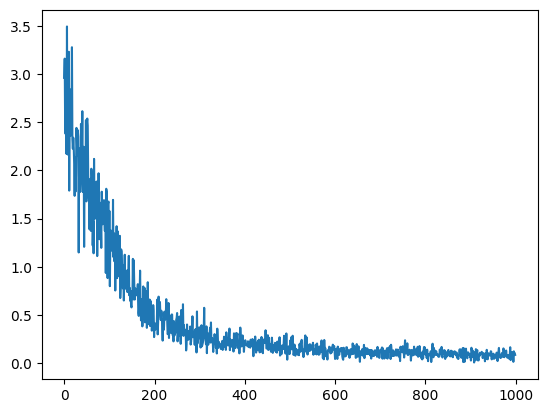

In [455]:
plt.plot(train_loss_teta)

In [456]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(training_set , batch_size, dim=0)
train_loss_pc = []
grad_norms_pc = []
train_err_pc = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = init_wrt_t_pol_chain(w1, w11, tetta, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        net.zero_grad()
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        acc = (logits.argmax(-1) == input[:, -1]).float().mean()
        total_acc += acc.item()*input.shape[0]
        loss.backward()
        grad = calc_norm(net)
        total_norm += grad
        counter += 1
    grad_norms_pc.append(total_norm / counter)
    train_err_pc.append(1 - total_acc / training_set.shape[0])
    train_loss_pc.append(total_loss/training_set.shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [457]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(validation_set , batch_size, dim=0)
val_loss_pc = []
val_err_pc = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = init_wrt_t_pol_chain(w1, w11, tetta, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        with torch.no_grad():
            input = input.to(device)  # используем видеокарту
            logits = net(input[:, :-1])  # предсказание
            loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
            total_loss += loss.item() * input.shape[0]
            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
    val_err_pc.append(1 - total_acc / validation_set.shape[0])
    val_loss_pc.append(total_loss/validation_set.shape[0])


  0%|          | 0/1000 [00:00<?, ?it/s]

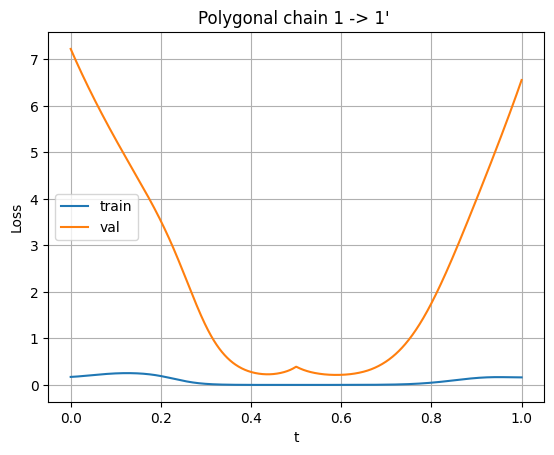

In [458]:
plt.plot(alpha_range, train_loss_pc, label='train')
plt.plot(alpha_range, val_loss_pc, label='val')
plt.grid()
plt.title('Polygonal chain 1 -> 1\' ')
plt.xlabel('t')
plt.legend()
plt.ylabel('Loss')
plt.savefig('exps/pol_chain11/train_val_loss.pdf')
plt.show()

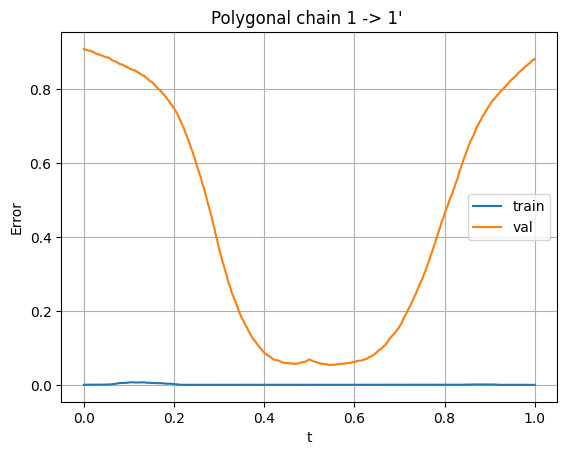

In [459]:
plt.plot(alpha_range, train_err_pc, label='train')
plt.plot(alpha_range, val_err_pc, label='val')
plt.grid()
plt.title('Polygonal chain 1 -> 1\' ')
plt.xlabel('t')
plt.legend()
plt.ylabel('Error')
plt.savefig('exps/pol_chain11/train_val_err.pdf')
plt.show()

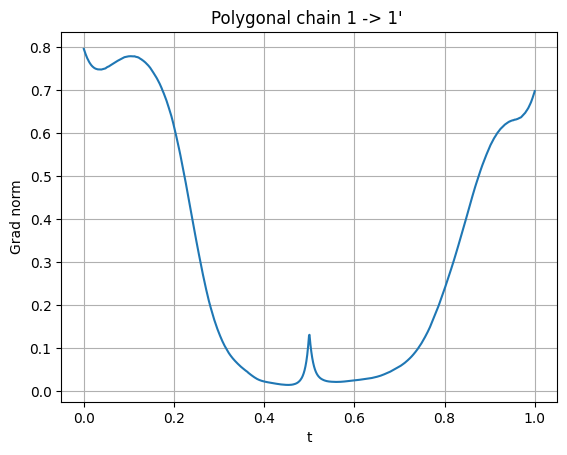

In [460]:
plt.plot(alpha_range, grad_norms_pc)
plt.grid()
plt.title('Polygonal chain 1 -> 1\' ')
plt.xlabel('t')
plt.ylabel('Grad norm')
plt.savefig('exps/pol_chain11/grad_norm.pdf')
plt.show()

## Connect 2 and 2'

In [461]:

net =   Transformer(num_layers=1, 
                    d_vocab=p, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=2, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)
optimizer = SGD(net.parameters(), lr=0.1, weight_decay=0.001)

In [462]:
dct_train_new = torch.load("dct_train_new")
net.load_state_dict(dct_train_new['model_state_dict'])
#optimizer.load_state_dict(dct_train_new['optimizer_state_dict'])
train_acc = dct_train_new["train_acc"]
val_acc = dct_train_new["val_acc"]
train_loss = dct_train_new["train_loss"]
val_loss = dct_train_new["val_loss"]
norms = dct_train_new["norms"]
grad_norms = dct_train_new["grad_norms"]
k = dct_train_new['epoch']

In [463]:
while True:
    k += 1
    # на каждой эпохе перемешиваем train
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    counter = 0
    total_grad_norm = 0
    for data, is_train in [(training_set, True), (validation_set, False)]:

        total_acc = 0
        total_loss = 0
        net.train(is_train)
        
        dl = torch.split(data , batch_size, dim=0)  # делим на батчи
        for input in dl:  # input - 1 батч
            input = input.to(device)  # используем видеокарту
            with torch.set_grad_enabled(is_train):
                logits = net(input[:, :-1])  # предсказание
                loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
                total_loss += loss.item() * input.shape[0]
                
            if is_train:  # пересчитываем веса, вычисляя градиенты; обновляем lr
                
                net.zero_grad()
                loss.backward()
                optimizer.step()
                grad = calc_norm(net)
                total_grad_norm += grad
                counter += 1
                

            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
            
        if is_train:
            train_acc.append(total_acc / training_set.shape[0])
            train_loss.append(total_loss / training_set.shape[0])
        else:
            val_acc.append(total_acc / validation_set.shape[0])
            val_loss.append(total_loss / validation_set.shape[0])
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in net.parameters())))
            grad_norms.append(total_grad_norm / counter)
    if val_acc[-1] == 1:
        dct = {
            'epoch': k,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            "train_acc": train_acc, 
            "val_acc": val_acc, 
            "train_loss": train_loss, 
            "val_loss": val_loss,
            "norms":norms, 
            "grad_norms":grad_norms
        }
        torch.save(dct, "dct_val_new")
        break
    print(f'Epoch {k}: Train / Val acc: {round(train_acc[-1], 4)} / {round(val_acc[-1], 4)}')


Epoch 582: Train / Val acc: 0.9997 / 0.1183
Epoch 583: Train / Val acc: 0.9997 / 0.1235
Epoch 584: Train / Val acc: 1.0 / 0.1238
Epoch 585: Train / Val acc: 0.9997 / 0.1288
Epoch 586: Train / Val acc: 1.0 / 0.1276
Epoch 587: Train / Val acc: 1.0 / 0.1314
Epoch 588: Train / Val acc: 1.0 / 0.1308
Epoch 589: Train / Val acc: 1.0 / 0.1351
Epoch 590: Train / Val acc: 1.0 / 0.1376
Epoch 591: Train / Val acc: 1.0 / 0.1392
Epoch 592: Train / Val acc: 1.0 / 0.1383
Epoch 593: Train / Val acc: 1.0 / 0.1412
Epoch 594: Train / Val acc: 1.0 / 0.1407
Epoch 595: Train / Val acc: 1.0 / 0.1458
Epoch 596: Train / Val acc: 1.0 / 0.1426
Epoch 597: Train / Val acc: 1.0 / 0.1471
Epoch 598: Train / Val acc: 1.0 / 0.151
Epoch 599: Train / Val acc: 1.0 / 0.1512
Epoch 600: Train / Val acc: 1.0 / 0.1546
Epoch 601: Train / Val acc: 1.0 / 0.1505
Epoch 602: Train / Val acc: 1.0 / 0.1548
Epoch 603: Train / Val acc: 1.0 / 0.1557
Epoch 604: Train / Val acc: 1.0 / 0.158
Epoch 605: Train / Val acc: 1.0 / 0.1598
Epoch 606

In [466]:
dct_val_new = torch.load('dct_val_new')
net.load_state_dict(dct_val_new['model_state_dict'])
w22 = get_ravel_weights(net)


In [467]:
tetta0 = (w2+w22)/2
num_iter = 1000

In [468]:
net =   Transformer(num_layers=1, 
                    d_vocab=p, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=2, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)
net.train(True)
optimizer = SGD(net.parameters(), lr=1e-1)

In [469]:
tetta = tetta0
train_loss_teta = []

In [470]:

for j in range(num_iter):
    training_set = training_set[torch.randperm(training_set.shape[0]), :]
    dl = torch.split(training_set , batch_size, dim=0)
    total_loss = 0
    for input in dl:  # input - 1 батч
        t = torch.rand(1)
        phi = init_wrt_t_pol_chain(w2, w22, tetta, t).detach().cpu().data.numpy()
        model_set_weights(net, phi)
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        net.zero_grad()
        loss.backward()

        if t <= 0.5:
            dphi = 2*t
        else:
            dphi = 2*(1-t)
        grad_arr = [] 
        dphi = dphi.to(device)
        for name, w in net.named_parameters():
            grad_arr.append(w.grad*dphi)
        model_set_weights(net, tetta)
        for i, (name, w) in enumerate(net.named_parameters()):
            w.grad = grad_arr[i]
        optimizer.step()
        tetta = get_ravel_weights(net)
    train_loss_teta.append(total_loss / training_set.shape[0])
    print(f'Epoch {j}: Train loss: {total_loss / training_set.shape[0]}')
    

Epoch 0: Train loss: 1.1317548029660922
Epoch 1: Train loss: 1.600285082959463
Epoch 2: Train loss: 2.5630912732104867
Epoch 3: Train loss: 1.3823752195187209
Epoch 4: Train loss: 1.2444929559299949
Epoch 5: Train loss: 1.8964646449022466
Epoch 6: Train loss: 0.9240346837120589
Epoch 7: Train loss: 2.3582742431878274
Epoch 8: Train loss: 1.490705808814691
Epoch 9: Train loss: 1.5770353966189505
Epoch 10: Train loss: 2.1956394463937596
Epoch 11: Train loss: 1.1173684773716583
Epoch 12: Train loss: 2.256107259129607
Epoch 13: Train loss: 1.7705145764647794
Epoch 14: Train loss: 2.283039770372188
Epoch 15: Train loss: 0.786303924950826
Epoch 16: Train loss: 1.1059470742652804
Epoch 17: Train loss: 0.5106918589000927
Epoch 18: Train loss: 1.1053233411719283
Epoch 19: Train loss: 1.2973462135784095
Epoch 20: Train loss: 2.5350006822612694
Epoch 21: Train loss: 0.8321323386452508
Epoch 22: Train loss: 1.7085216834132833
Epoch 23: Train loss: 1.264821370085251
Epoch 24: Train loss: 1.25605252

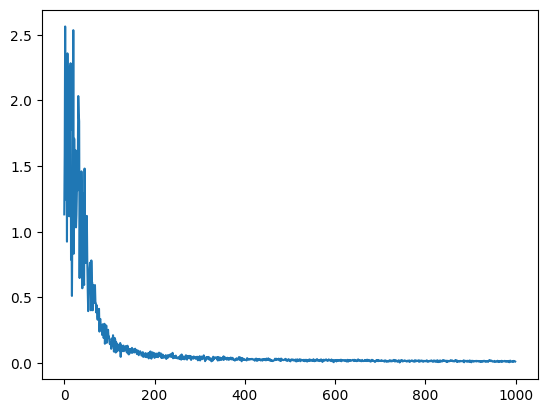

In [471]:
plt.plot(train_loss_teta)

In [472]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(training_set , batch_size, dim=0)
train_loss_pc = []
grad_norms_pc = []
train_err_pc = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = init_wrt_t_pol_chain(w2, w22, tetta, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        net.zero_grad()
        input = input.to(device)  # используем видеокарту
        logits = net(input[:, :-1])  # предсказание
        loss = cross_entropy(
                logits, input[:, -1].flatten().to(torch.long))
        total_loss += loss.item() * input.shape[0]
        acc = (logits.argmax(-1) == input[:, -1]).float().mean()
        total_acc += acc.item()*input.shape[0]
        loss.backward()
        grad = calc_norm(net)
        total_norm += grad
        counter += 1
    grad_norms_pc.append(total_norm / counter)
    train_err_pc.append(1 - total_acc / training_set.shape[0])
    train_loss_pc.append(total_loss/training_set.shape[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [473]:
alpha_range = np.linspace(0, 1, 1000)
dl = torch.split(validation_set , batch_size, dim=0)
val_loss_pc = []
val_err_pc = []
for a in tqdm(alpha_range):
    total_loss = 0
    total_acc = 0
    total_norm = 0
    phi = init_wrt_t_pol_chain(w2, w22, tetta, a)
    model_set_weights(net, phi)
    counter = 0 
    for input in dl:  # input - 1 батч
        with torch.no_grad():
            input = input.to(device)  # используем видеокарту
            logits = net(input[:, :-1])  # предсказание
            loss = cross_entropy(
                    logits, input[:, -1].flatten().to(torch.long))
            total_loss += loss.item() * input.shape[0]
            acc = (logits.argmax(-1) == input[:, -1]).float().mean()
            total_acc += acc.item()*input.shape[0]
    val_err_pc.append(1 - total_acc / validation_set.shape[0])
    val_loss_pc.append(total_loss/validation_set.shape[0])


  0%|          | 0/1000 [00:00<?, ?it/s]

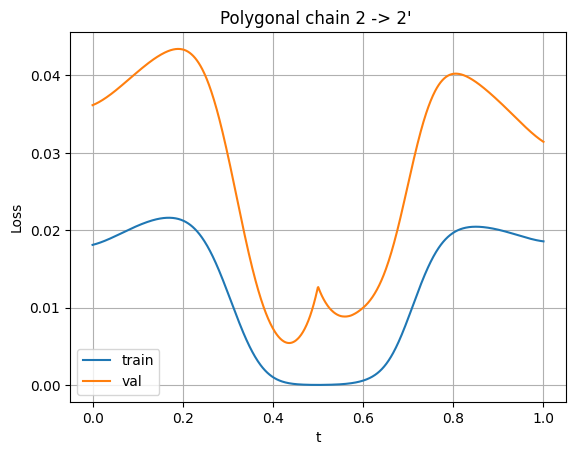

In [474]:
plt.plot(alpha_range, train_loss_pc, label='train')
plt.plot(alpha_range, val_loss_pc, label='val')
plt.grid()
plt.title('Polygonal chain 2 -> 2\' ')
plt.xlabel('t')
plt.legend()
plt.ylabel('Loss')
plt.savefig('exps/pol_chain22/train_val_loss.pdf')
plt.show()

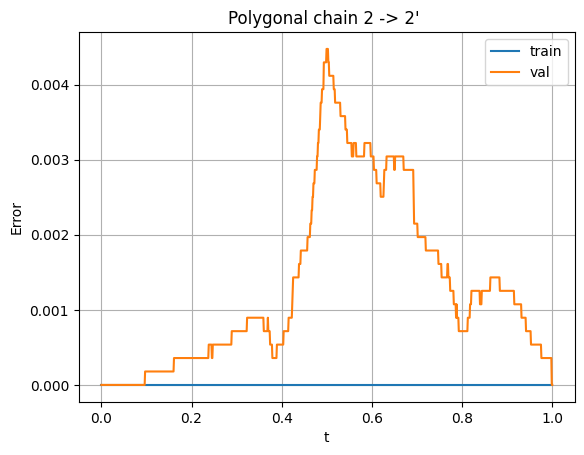

In [475]:
plt.plot(alpha_range, train_err_pc, label='train')
plt.plot(alpha_range, val_err_pc, label='val')
plt.grid()
plt.title('Polygonal chain 2 -> 2\' ')
plt.xlabel('t')
plt.legend()
plt.ylabel('Error')
plt.savefig('exps/pol_chain22/train_val_err.pdf')
plt.show()

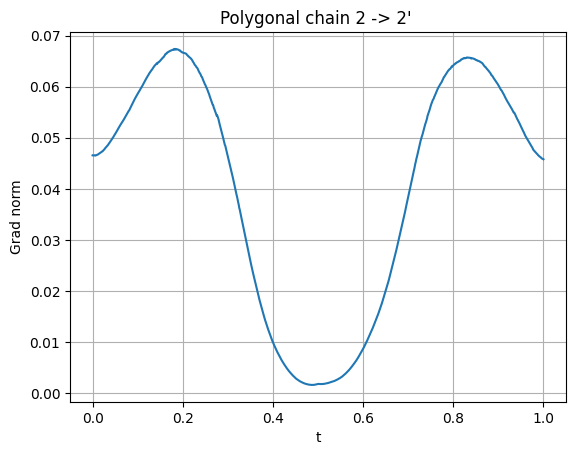

In [476]:
plt.plot(alpha_range, grad_norms_pc)
plt.grid()
plt.title('Polygonal chain 2 -> 2\' ')
plt.xlabel('t')
plt.ylabel('Grad norm')
plt.savefig('exps/pol_chain22/grad_norm.pdf')
plt.show()

Заметим, что графики трейн лосса и нормы градиента кореллируют, что, наверно логично: чем ближе к минимуму, тем меньше градиент.
### 1 и 2
Норма градиента убывает и, начиная с $t = 0.4$, становится близкой к нулю. Также ошибка на тесте с этого момента падает. Из этого можно сделать вывод, что мы из узкого минимума с помощью pol. chain переходим в широкий.
### 1 и 1' 
Как и ожидалось, согласно статье, соединили два оптимума кривой с низким лоссом. Норма градиента высокая как в конечной точке, так и в начальной. То есть по факту мы с помощью "тунелля" передвинулись из одного узкого минимума в другой, по пути пересекая различные минимумы (это хорошо заметно на графике тест лосса)
### 2 и 2. 
Норма градиента в десять раз меньше, чем у точки 1. Передвигаясь по кривой, имеем практически везде нулевую ошибку, кроме окрестости $t = 0.8$. Видимо, пока передвигались между широкими минимумами, встретили более узкий. 